### Initial Imports and loading. The dataset is used is <a href='https://www.kaggle.com/adityajn105/flickr8k'>Flickr 8k</a> from kaggle.

In [2]:
#location of the training data 
data_location =  "../input/flickr8k"

#imports
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader,Dataset, Subset
from torch.nn.utils.rnn import pad_sequence
import torchvision.transforms as T
import os
from collections import Counter
from PIL import Image
from sklearn.model_selection import train_test_split

import spacy
spacy_eng = spacy.load("en_core_web_sm")

### Implementing the Helper function to plot the Tensor image

In [3]:
#show the tensor image
import matplotlib.pyplot as plt
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

### Custom dataset and dataloader is adapted from <a href="https://www.kaggle.com/mdteach/torch-data-loader-flicker-8k">this</a> notebook.

In [4]:
class Vocabulary:
    def __init__(self,freq_threshold):
        #setting the pre-reserved tokens int to string tokens
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        
        #string to int tokens
        #its reverse dict self.itos
        self.stoi = {v:k for k,v in self.itos.items()}
        
        self.freq_threshold = freq_threshold
        
    def __len__(self): return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]
    
    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4
        
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                
                #add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self,text):
        """ For each word in the text corresponding index token for that word form the vocab built as list """
        tokenized_text = self.tokenize(text)
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]    

In [5]:
class FlickrDataset(Dataset):
    """
    FlickrDataset
    """
    def __init__(self,root_dir,caption_file,transform=None,freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(caption_file)
        self.transform = transform
        
        #Get image and caption colum from the dataframe
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        
        #Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())
        
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")
        
        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)
        
        #numericalize the caption text
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]
        
        return img, torch.tensor(caption_vec)

In [6]:
class CapsCollate:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets

In [53]:
#Initiate the Dataset and Dataloader

#setting the constants
data_location =  "../input/flickr8k"
TRAIN_BATCH_SIZE = 256
TEST_BATCH_SIZE = 1
NUM_WORKER = 4

#defining the transform to be applied
transforms = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])


# building dataset class
dataset =  FlickrDataset(
    root_dir = data_location+"/Images",
    caption_file = data_location+"/captions.txt",
    transform=transforms
)

# token to represent the padding
pad_idx = dataset.vocab.stoi["<PAD>"]

# Train-test split
train_idx, test_idx = train_test_split(range(len(dataset)), test_size=0.15, random_state=25)

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

# building data loaders
train_data_loader = DataLoader(
    dataset=train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)

test_data_loader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)

#vocab_size
vocab_size = len(dataset.vocab)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

34386
6069


device(type='cuda', index=0)

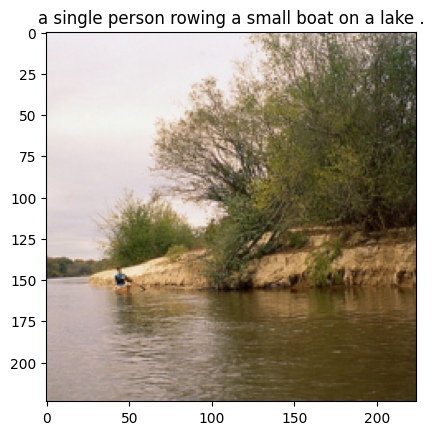

In [8]:
# Testing dataloader
#generating the iterator from the dataloader
dataiter = iter(test_data_loader)

#getting the next batch
batch = next(dataiter)

#unpacking the batch
images, captions = batch

#showing info of image in single batch
for i in range(TEST_BATCH_SIZE):
    img,cap = images[i],captions[i]
    caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
    eos_index = caption_label.index('<EOS>')
    caption_label = caption_label[1:eos_index]
    caption_label = ' '.join(caption_label)                      
    show_image(img,caption_label)
    plt.show()

### Defining the Model Architecture

Model is seq2seq model. In the **encoder** pretrained ResNet model is used to extract the features. Decoder, is the implementation of the Bahdanau Attention Decoder. In the decoder model **LSTM cell**.

In [9]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

In [10]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        

    def forward(self, images):
        features = self.resnet(images)                                    #(batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        return features


In [11]:
#Bahdanau Attention
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim
        
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        
        self.A = nn.Linear(attention_dim,1)
        
        
        
        
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)
        
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)
        
        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)
        
        
        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)
        
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)
        
        return alpha,attention_weights
        

In [12]:
#Attention Decoder
class AttentionDecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
        
    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
                
        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.fcn(self.drop(h))
            
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        
        return preds, alphas
    
    def generate_caption(self,features,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        alphas = []
        
        #starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        
        captions = []
        
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            
            
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions],alphas
    
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c


In [13]:
class NoAttentionDecoderRNN(nn.Module):
    def __init__(self, embed_size, vocab_size, encoder_dim, decoder_dim, drop_prob=0.3):
        super().__init__()
        
        # Save the model parameters
        self.vocab_size = vocab_size
        self.decoder_dim = decoder_dim
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        # Initialize hidden and cell states
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        
        # LSTM cell
        self.lstm_cell = nn.LSTMCell(embed_size, decoder_dim, bias=True)
        
        # Fully connected layer
        self.fcn = nn.Linear(decoder_dim, vocab_size)
        
        # Dropout layer
        self.drop = nn.Dropout(drop_prob)
    
    def forward(self, features, captions):
        # Vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)
        
        # Get the sequence length to iterate
        seq_length = len(captions[0]) - 1  # Exclude the last one
        batch_size = captions.size(0)
        
        # Prepare tensor to store predictions
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        
        for s in range(seq_length):
            # LSTM input using only embeddings
            h, c = self.lstm_cell(embeds[:, s], (h, c))
            
            # Compute output and store predictions
            output = self.fcn(self.drop(h))
            preds[:, s] = output
        
        return preds, _
    
    def generate_caption(self, features, max_len=20, vocab=None):
        # Inference part: generate the captions given image features
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)
        
        # Starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1, -1).to(device)
        embeds = self.embedding(word)
        
        captions = []
        
        for i in range(max_len):
            # Use LSTM cell to generate predictions
            h, c = self.lstm_cell(embeds[:, 0], (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size, -1)
            
            # Select the word with the highest value
            predicted_word_idx = output.argmax(dim=1)
            captions.append(predicted_word_idx.item())
            
            # End if <EOS> detected
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            # Prepare next input
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        # Convert the vocab indexes to words and return the sentence
        return [vocab.itos[idx] for idx in captions], _
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c


In [14]:
class AttentionEncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = AttentionDecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs


In [15]:
class NoAttentionEncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = NoAttentionDecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

### Setting Hypperparameter and Init the model

In [16]:
#Hyperparams
embed_size=300
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4


In [17]:
#init model
attentionModel = AttentionEncoderDecoder(
    embed_size=embed_size,
    vocab_size = vocab_size,
    attention_dim=attention_dim,
    encoder_dim=encoder_dim,
    decoder_dim=decoder_dim
).to(device)

#init model
noAttentionModel = NoAttentionEncoderDecoder(
    embed_size=embed_size,
    vocab_size = vocab_size,
    encoder_dim=encoder_dim,
    decoder_dim=decoder_dim
).to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 160MB/s] 


In [18]:
#helper function to save the model
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'attention_model_state.pth')

## Training Job from above configs

In [33]:
# Training Loop
def train_image_captioner(model, data_loader, criterion, optimizer, num_epochs=25, print_every=100):
    for epoch in range(1,num_epochs+1):   
        for idx, (image, captions) in enumerate(iter(data_loader)):
            image,captions = image.to(device),captions.to(device)

            # Zero the gradients.
            optimizer.zero_grad()

            # Feed forward
            outputs,attentions = model(image, captions)

            # Calculate the batch loss.
            targets = captions[:,1:]
            loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

            # Backward pass.
            loss.backward()

            # Update the parameters in the optimizer.
            optimizer.step()

            if (idx+1)%print_every == 0:
                print("Epoch: {} loss: {:.5f}".format(epoch+25,loss.item()))


                #generate the caption
                model.eval()
                with torch.no_grad():
                    dataiter = iter(data_loader)
                    img,_ = next(dataiter)
                    features = model.encoder(img[0:1].to(device))
                    caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
                    caption = ' '.join(caps)
                    show_image(img[0],title=caption)

                model.train()

        #save the latest model
        save_model(model,epoch)

Epoch: 26 loss: 1.93493


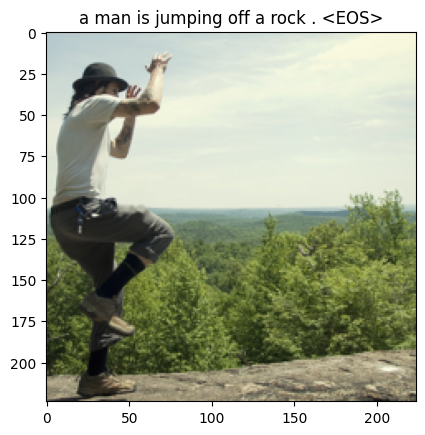

Epoch: 27 loss: 2.13369


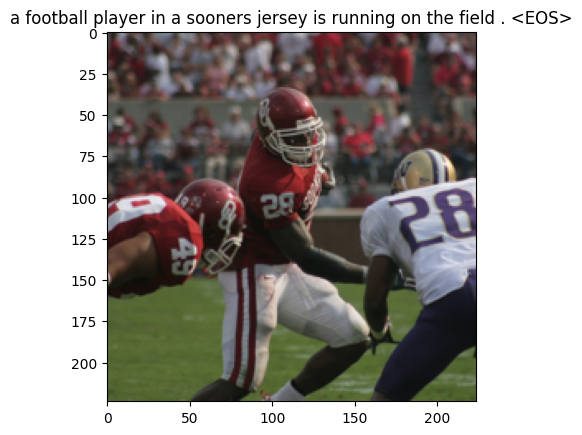

Epoch: 28 loss: 2.06620


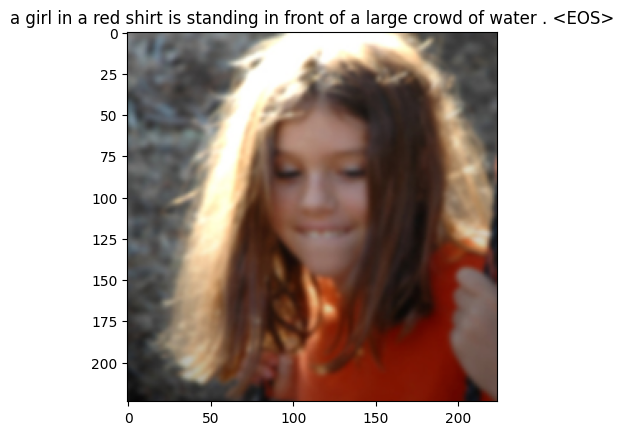

Epoch: 29 loss: 2.01229


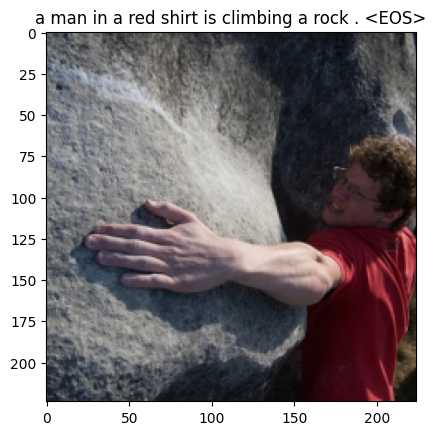

Epoch: 30 loss: 1.99391


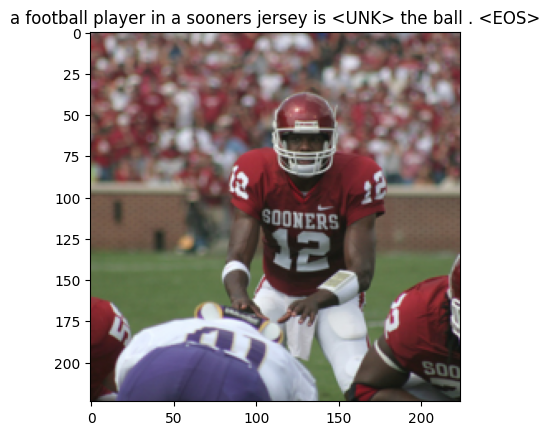

Epoch: 31 loss: 2.04554


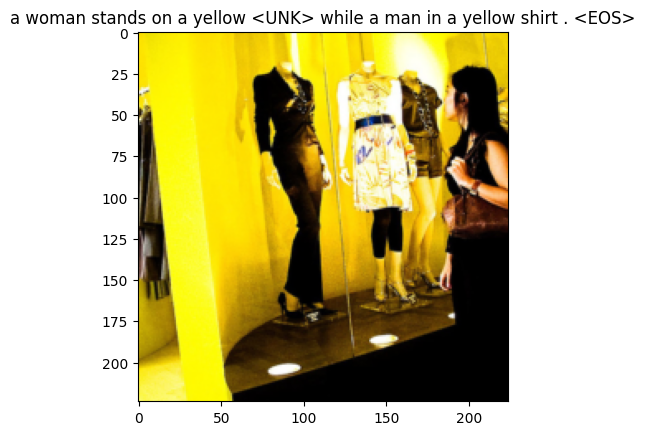

Epoch: 32 loss: 1.96423


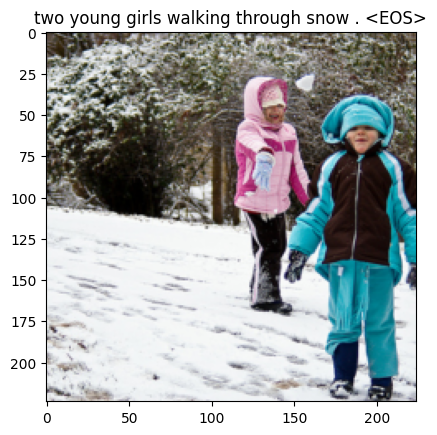

Epoch: 33 loss: 1.95165


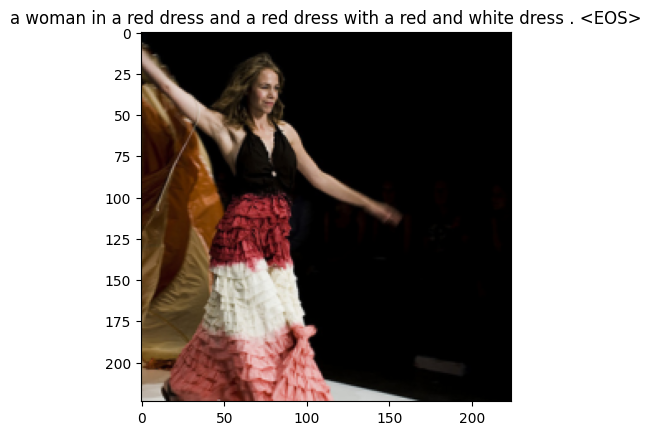

Epoch: 34 loss: 1.89465


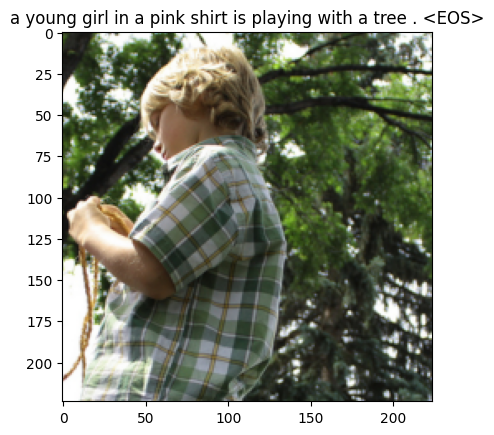

Epoch: 35 loss: 1.94775


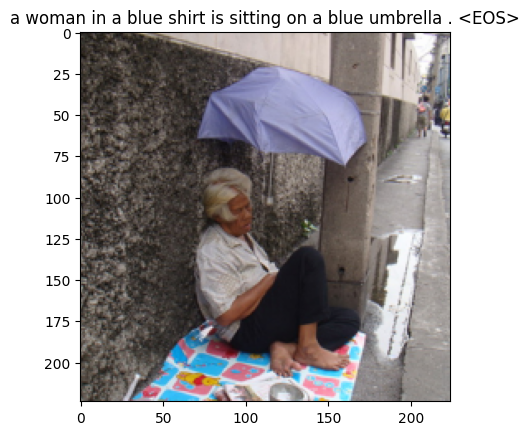

Epoch: 36 loss: 1.93822


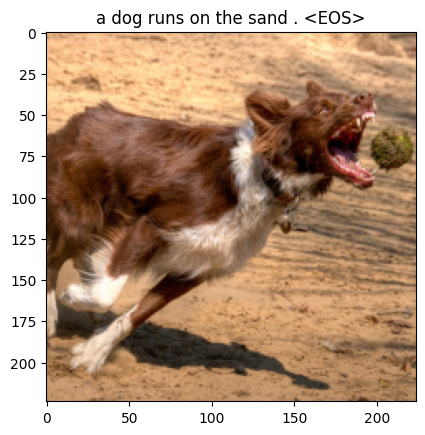

Epoch: 37 loss: 1.82208


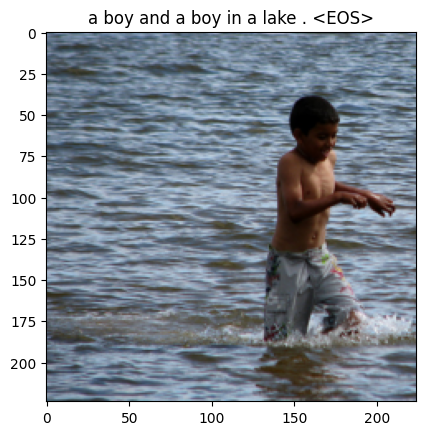

Epoch: 38 loss: 1.83835


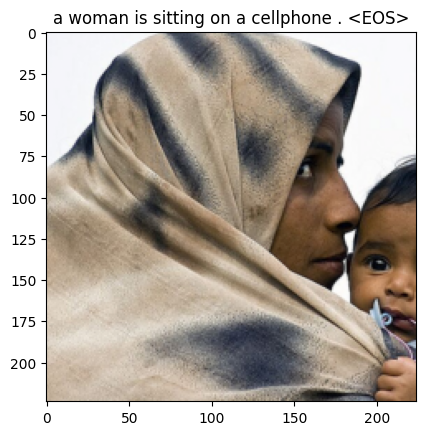

Epoch: 39 loss: 1.80452


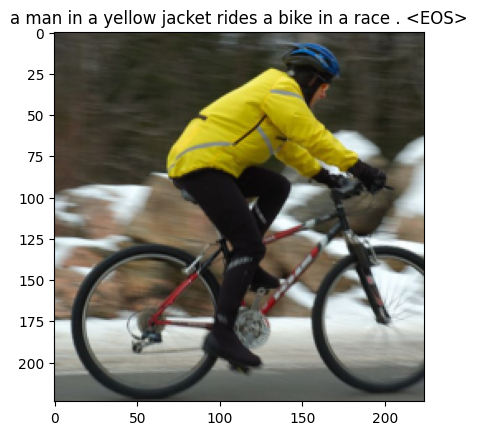

Epoch: 40 loss: 1.86125


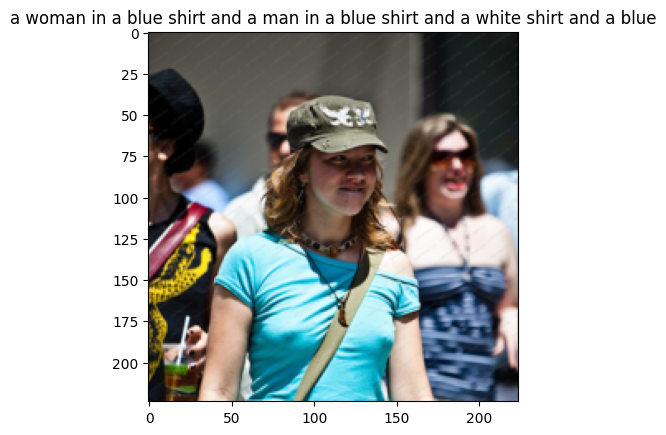

In [34]:
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(attentionModel.parameters(), lr=learning_rate)

train_image_captioner(attentionModel, train_data_loader, criterion, optimizer, num_epochs=15, print_every=100)

In [20]:
# Load Model
model_state = torch.load("/kaggle/input/trained_image_captioner_attention/pytorch/25_epoch/1/attention_model_state (2).pth")
attentionModel.load_state_dict(model_state['state_dict'])

<All keys matched successfully>

## Visualizing the attentions
Defining helper functions
<li>Given the image generate captions and attention scores</li>
<li>Plot the attention scores in the image</li>

In [35]:
#generate caption
def get_caps_from(features_tensors, model):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)
    
    return caps,alphas

#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()

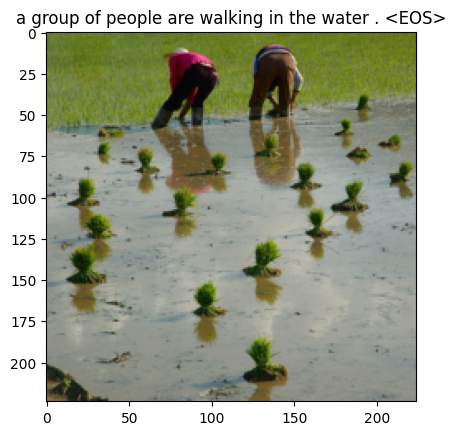

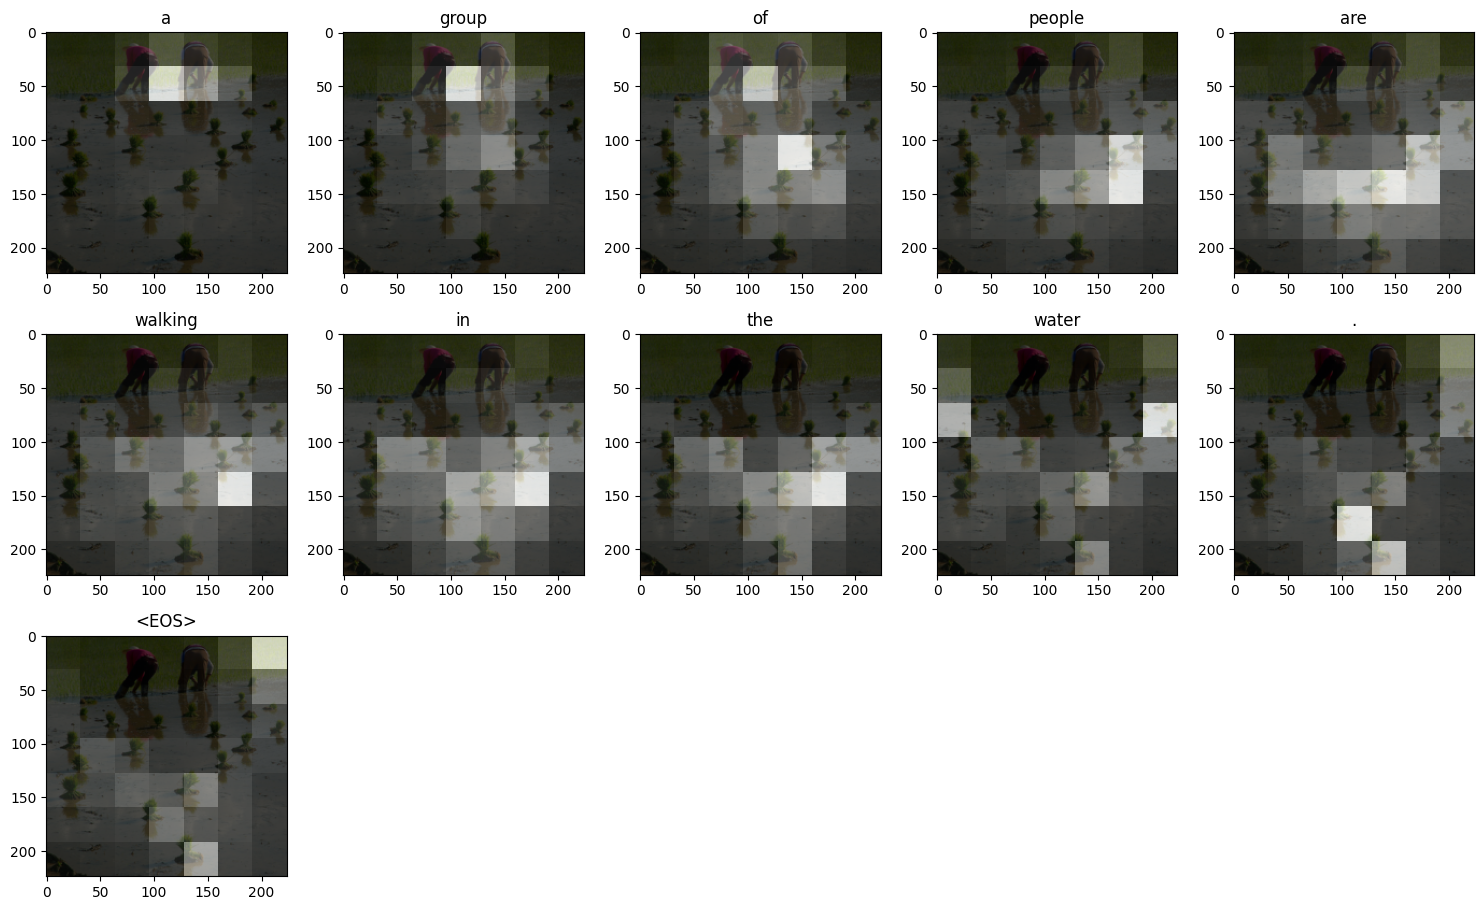

In [36]:
#show any 1
dataiter = iter(test_data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0), attentionModel)

plot_attention(img1, caps, alphas)

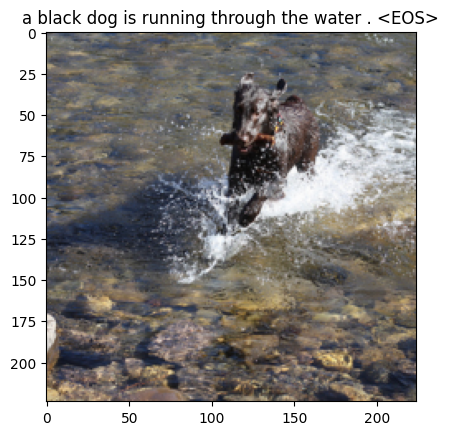

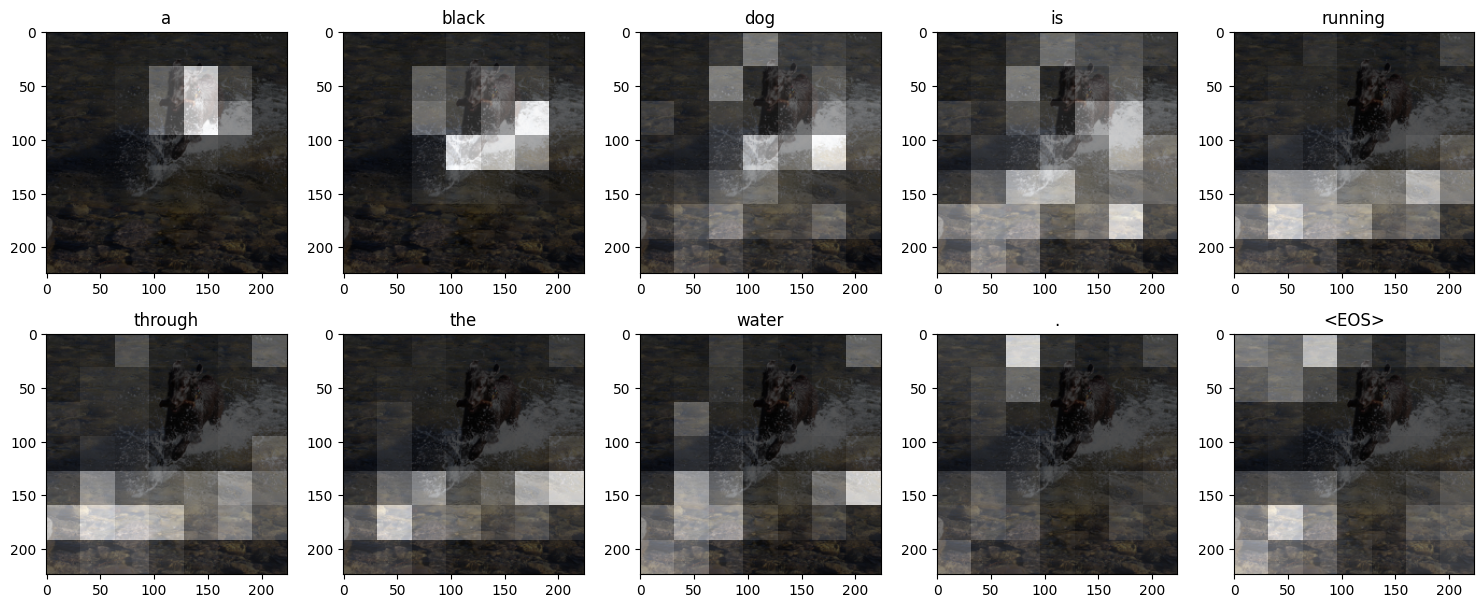

In [37]:
#show any 1
dataiter = iter(test_data_loader)
images,_ = next(dataiter)
img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0), attentionModel)

plot_attention(img1, caps, alphas)

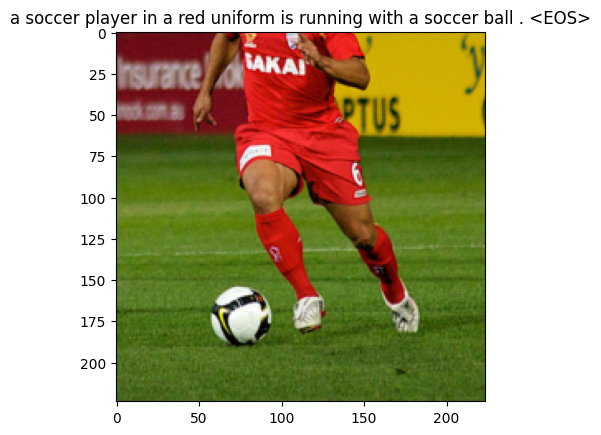

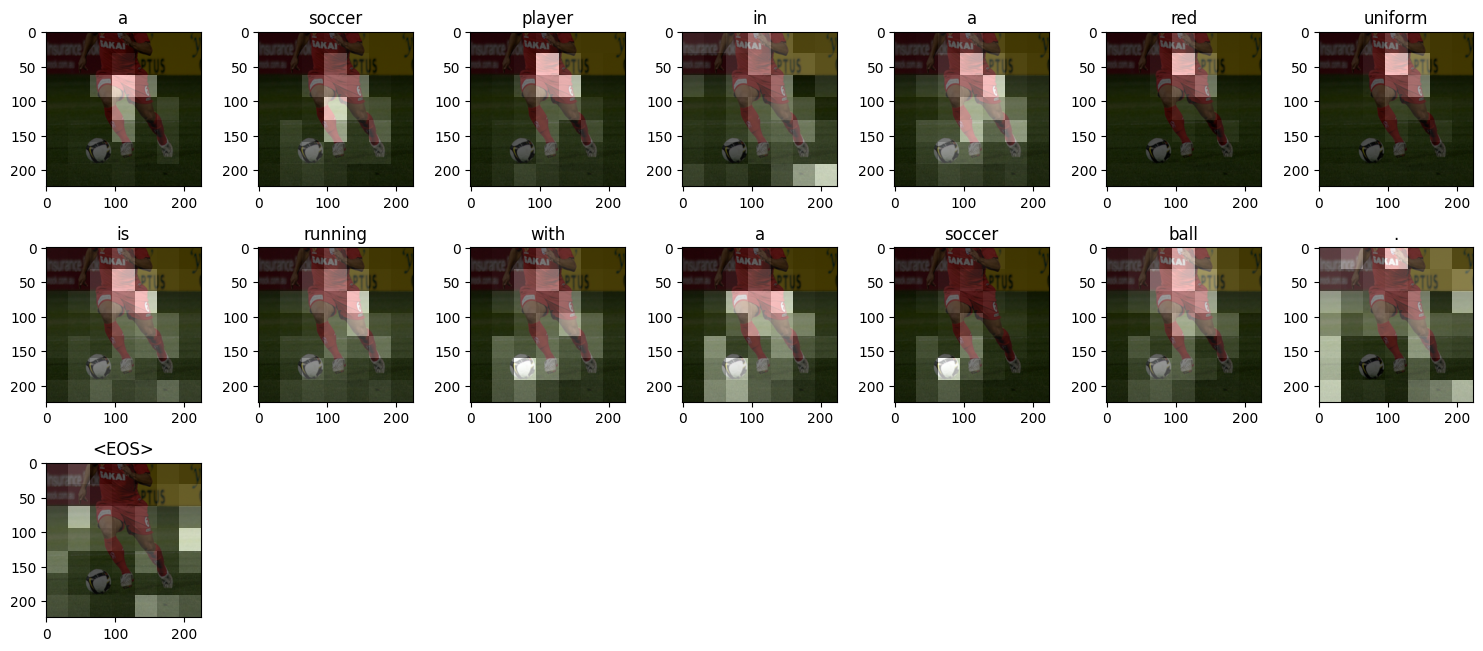

In [38]:
#show any 1
dataiter = iter(test_data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0), attentionModel)

plot_attention(img1, caps, alphas)

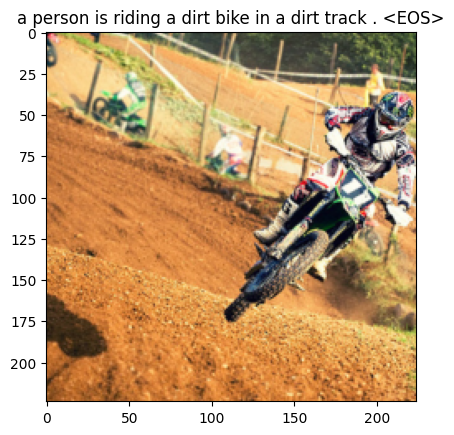

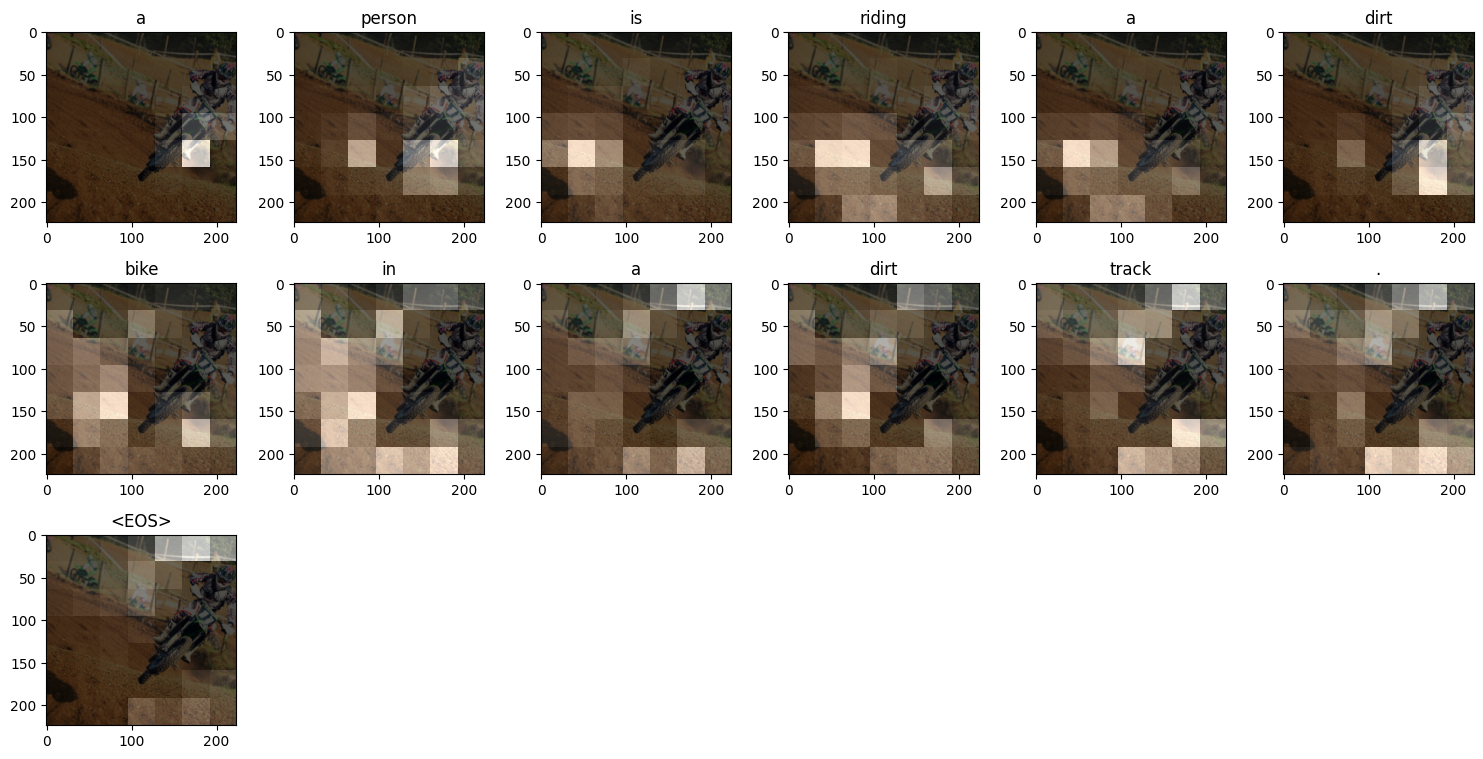

In [55]:
#show any 1
dataiter = iter(test_data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0), attentionModel)

plot_attention(img1, caps, alphas)

### Evaluation

In [40]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [41]:
def calculate_bleu_score(reference_list, prediction_list):
    # Calc score
    chencherry = SmoothingFunction()
    score = sentence_bleu(
        references=reference_list, 
        hypothesis=prediction_list, 
        smoothing_function=chencherry.method2)
    
    return score

In [51]:
def evaluate_model(model, test_loader, vocab):
    model.eval()
    bleu_scores = []
    for idx, (image, captions) in enumerate(iter(test_loader)):
        with torch.no_grad():
            # encode image
            features = model.encoder(image.to(device))
            # generate caption
            caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
            # format caption
            predicted_caps = caps[0:-1]
            true_caption_ints = captions[0].tolist()
            true_caption = [vocab.itos[idx] for idx in true_caption_ints]
            true_caps = true_caption[1:-1]
            # get blue score
            bleu_score = calculate_bleu_score(true_caps, predicted_caps)
            bleu_scores.append(bleu_score)
            if (idx % 100) == 0:
                formatted_caption = ' '.join(predicted_caps)
                # print
                print(f"idx: {idx}")
                print(f"Generated Caption: {formatted_caption}")
                print(f"True Caption: {' '.join(true_caps)}")
                print(f"Bleu Score: {bleu_score}")
                # show
#                 show_image(image[0],title=f"{formatted_caption}")
    return bleu_scores, np.average(bleu_scores)

In [52]:
scores, avg_score = evaluate_model(attentionModel, test_data_loader, dataset.vocab)

idx: 0
Generated Caption: a young boy runs through a field .
True Caption: a child runs through a field .
Bleu Score: 0.17747405280050263
idx: 100
Generated Caption: a basketball player in a white uniform is dribbling the ball .
True Caption: a basketball player runs while another tries to block him .
Bleu Score: 0.1235622127262679
idx: 200
Generated Caption: a black and white dog is playing with a blue ball .
True Caption: a black dog and a white dog play with each other and a green ball .
Bleu Score: 0.11498759556447223
idx: 300
Generated Caption: two dogs are playing with a ball in the grass .
True Caption: a white dog and brown dog fighting .
Bleu Score: 0.12605968092174913
idx: 400
Generated Caption: a girl slides down a green slide .
True Caption: a young girl is sliding down a slide at a playground .
Bleu Score: 0.17747405280050263
idx: 500
Generated Caption: a soccer game in progress .
True Caption: a group of kids in red and white playing soccer .
Bleu Score: 0.244461511217450

In [54]:
print(avg_score)

0.12860337774236827
